# Phone Price Prediction Project

In [1]:
import re
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import seaborn as sns
from itables import show

In [2]:
df = pd.read_csv('phone_data.csv', index_col='Unnamed: 0')

In [3]:
show(df, maxBytes=0)

The column names are in Indonesian and they contain spaces. Let's translate them to english and standardize the column format using `column_mapper.csv` before we proceed to data analysis

In [4]:
column_mapper = pd.read_csv('column_mapper.csv', index_col='col_id').squeeze().to_dict()
df.columns = df.columns.map(column_mapper)
df.columns

Index(['price', 'category', 'brand', 'release_year', 'product_name',
       '2g_network', '3g_network', '4g_network', 'network', 'dimension',
       'weight', 'num_sim_slots', 'sim_card_type', 'color',
       'screen_resolution', 'screen_size', 'technology', 'os_version',
       'os_version_detail', 'os', 'processor', 'processor_detail', 'cpu_speed',
       'gpu', 'num_core', 'ram', 'internal_memory', 'external_memory_type',
       'back_camera_resolution', 'other_main_camera_resolution',
       'has_dual_back_camera', 'num_back_camera', 'front_camera_resolution',
       'has_dual_front_camera', 'has_flash', 'has_dual_flash', 'video',
       'has_nfc', 'has_infrared', 'usb', 'wifi', 'bluetooth', 'gps',
       'battery_type', 'battery_material', 'battery_capacity', 'is_waterproof',
       'cencor', 'has_3.5mm_jack', '5g_network', 'material',
       'external_memory_capacity', 'has_fast_charging', 'fast_charging_power',
       'series', 'front_camera_resolution_2'],
      dtype='object')

# 1. Data Cleaning and Column Transformation

In [5]:
show(df, maxBytes=0)

We can see that the scraped datas are not very workable since they are all stored as string. We'll first transform this values into numerical for easier analysis

In [6]:
clean_df = df.copy()

In [7]:
## Extract price
clean_df['price'] = clean_df['price'].str.split("Rp").str[1].str.replace(".", "").astype(float)

In [8]:
## Map Yes or No values to 0 and 1
boolean_cols = [col for col in clean_df.columns if 'has' in col or 'is' in col]
for col in boolean_cols:
    clean_df[col] = clean_df[col].map({'Yes':1, 'No':0})

In [9]:
## Drop category
clean_df = clean_df.drop(columns=['category'])

In [10]:
## Extract memory related values
def extract_memory(string):
    if pd.isnull(string):
        return None
    
    if 'GB' in string:
        return float(string.split('GB')[0])
    
    if 'TB' in string:
        return float(string.split('TB')[0]) * 1024

memory_cols = ['ram', 'internal_memory']
for col in memory_cols:
    clean_df[col] = clean_df[col].apply(extract_memory)

In [11]:
## Extract camera related values
camera_resolution_cols = ['back_camera_resolution', 'front_camera_resolution', 'front_camera_resolution_2']
for col in camera_resolution_cols:
    clean_df[col] = clean_df[col].str.split('MP').str[0].astype(float)

In [12]:
## Extract values with constant unit
clean_df['weight'] = clean_df['weight'].str.split('g').str[0].astype(float)
clean_df['num_sim_slots'] = clean_df['num_sim_slots'].str.split('slot').str[0].astype(float)
clean_df['screen_size'] = clean_df['screen_size'].str.split('inch').str[0].astype(float)
clean_df['cpu_speed'] = clean_df['cpu_speed'].str.split('GHz').str[0].astype(float)
clean_df['battery_capacity'] = clean_df['battery_capacity'].str.split('mAh').str[0].astype(float)

In [13]:
## Extract external memory capacity
def extract_memory_capacity(string):
    if pd.isnull(string):
        return None
    
    match = re.search(r'(\d+)\s*(GB|TB)', string, re.IGNORECASE)
    if match:
        value = int(match.group(1))
        return value * 1024 if match.group(2).upper() == 'TB' else value
    return None

clean_df['external_memory_capacity'] = clean_df['external_memory_capacity'].apply(extract_memory_capacity)

### Transforming network column

We'll drop `2g,3g,4g,5g_network` columns since the details are pretty hard to put into the models and instead, we'll just create boolean columns indicating whether a phone has 2g,3g,4g,5g network

In [14]:
## Transforming network column
for i in range(2,6):
    clean_df[f'has_{i}G_network'] = np.logical_or(f'{i}G' in clean_df['network'], ~clean_df[f'{i}g_network'].isnull())
    clean_df[f'has_{i}G_network'] = clean_df[f'has_{i}G_network'].astype(int)
clean_df = clean_df.drop(columns=['2g_network', '3g_network', '4g_network', '5g_network', 'network'])

### Transforming material column

In [15]:
def extract_materials(description):
    if pd.isnull(description):
        return ('unspecified', 'unspecified', 'unspecified')
    # Define patterns for each component
    front_pattern = r'(glass|plastic|metal)(?=\s+front)'
    back_pattern = r'(glass|plastic|metal)(?=\s+back)'
    frame_pattern = r'(titanium|aluminum|steel|plastic)(?=\s+frame)'

    # Search for patterns in the description
    front_match = re.search(front_pattern, description, re.IGNORECASE)
    back_match = re.search(back_pattern, description, re.IGNORECASE)
    frame_match = re.search(frame_pattern, description, re.IGNORECASE)

    # Extract the matched materials
    front_material = front_match.group(0) if front_match else 'unspecified'
    back_material = back_match.group(0) if back_match else 'unspecified'
    frame_material = frame_match.group(0) if frame_match else 'unspecified'

    return front_material.lower(), back_material.lower(), frame_material.lower()

In [16]:
material_df = pd.DataFrame(
    clean_df['material'].apply(extract_materials).to_list(),
    columns=['front_material', 'back_material', 'frame_material'],
    index=clean_df.index
    )
clean_df = pd.concat([clean_df, material_df], axis=1)
clean_df = clean_df.drop(columns=['material'])

### Transforming other main camera

In [17]:
# Define functions to compute mean, max, and min, handling conversion from strings
def safe_mean(lst):
    if isinstance(lst, list):
        num_lst = [float(i) for i in lst if i.isnumeric()]
        if num_lst:
            return np.mean(num_lst)
    return 0

def safe_max(lst):
    if isinstance(lst, list):
        num_lst = [float(i) for i in lst if i.isnumeric()]
        if num_lst:
            return np.max(num_lst)
    return 0

def safe_min(lst):
    if isinstance(lst, list):
        num_lst = [float(i) for i in lst if i.isnumeric()]
        if num_lst:
            return np.min(num_lst)
    return 0

In [18]:
other_main_camera = clean_df['other_main_camera_resolution'].str.split('MP').str[0].str.strip().str.split(',')

clean_df['other_main_camera_mean'] = other_main_camera.apply(safe_mean)
clean_df['other_main_camera_max'] = other_main_camera.apply(safe_max)
clean_df['other_main_camera_min'] = other_main_camera.apply(safe_min)

In [19]:
clean_df = clean_df.drop(columns=['other_main_camera_resolution'])

In [20]:
show(clean_df, maxBytes=0)

## 2. Handling Missing Values

In [21]:
def compute_missing_values_pct(df):
    missing_values = pd.DataFrame(columns=['count', 'percentage'])
    missing_values['count'] = df.isnull().astype(int).sum()
    missing_values['percentage'] = missing_values['count'] / df.shape[0]
    missing_values = missing_values.sort_values(by='percentage', ascending=False)

    return missing_values

def show_non_missing(df, col):
    show(df.loc[~df[col].isnull(), [col, 'product_name', 'price']])

In [22]:
missing_values_pct = compute_missing_values_pct(clean_df)
show(missing_values_pct)

### 1a. Remove missing `price`

In [23]:
clean_df = clean_df.dropna(subset=['price'])
show(compute_missing_values_pct(clean_df))

### 1b. Remove columns with > 65% missing values

In [24]:
missing_values_pct = compute_missing_values_pct(clean_df)
missing_values_pct = missing_values_pct[missing_values_pct['percentage'] >= 0.65]
clean_df = clean_df.drop(columns=missing_values_pct.index)

In [25]:
show(compute_missing_values_pct(clean_df))

### 1c. Fill categorical cols with mode

In [26]:
boolean_cols = [col for col in clean_df.columns if 'has' in col or 'is' in col]
boolean_fill_value_dict = {
    col:clean_df[col].mode()[0] for col in boolean_cols if col in clean_df.columns
}
clean_df = clean_df.fillna(boolean_fill_value_dict)

In [27]:
show(compute_missing_values_pct(clean_df))

### 1d. Fill numerical cols with mean

In [28]:
fill_with_mean_cols = [
    'weight', 'cpu_speed', 'ram', 'back_camera_resolution',
    'front_camera_resolution', 'release_year', 'battery_capacity',
    'screen_size'
]
clean_df = clean_df.fillna(clean_df[fill_with_mean_cols].mean().to_dict())

In [29]:
show(compute_missing_values_pct(clean_df))

### 1e. Drop categorical cols with too many possible values

In [30]:
missing_values_pct = compute_missing_values_pct(clean_df).loc[clean_df.dtypes=='object']
missing_values_pct = missing_values_pct[missing_values_pct['percentage'] > 0]

In [31]:
too_many_unique = clean_df.loc[:, missing_values_pct.index].nunique()
too_many_unique = too_many_unique[too_many_unique > 10].index
too_many_unique

Index(['technology', 'os_version_detail', 'bluetooth', 'color',
       'processor_detail', 'gpu', 'dimension', 'cencor', 'wifi', 'video',
       'usb', 'gps', 'screen_resolution'],
      dtype='object')

In [32]:
clean_df = clean_df.drop(columns=too_many_unique)

In [33]:
show(compute_missing_values_pct(clean_df))

### Handling external memory type

In [34]:
clean_df = clean_df.fillna({'external_memory_type':clean_df['external_memory_type'].mode()[0]})

### Handling float cols with mean

In [35]:
show(compute_missing_values_pct(clean_df))

In [36]:
clean_df['battery_type'].value_counts()

battery_type
Non-Removable    1214
Removable          54
Non-removable       7
Name: count, dtype: int64

In [37]:
clean_df.loc[clean_df['battery_type']=='Non-removable', 'battery_type'] = 'Non-Removable'

In [38]:
clean_df['num_core'].value_counts()

num_core
Octa Core     1099
Hexa Core       86
Quad Core       77
Dual Core       17
Deca Core        9
Hepta Core       1
Name: count, dtype: int64

In [39]:
clean_df['num_core'] = clean_df['num_core'].map({
    'Octa Core':8,
    'Hexa Core':6,
    'Quad Core':4,
    'Dual Core':2,
    'Deca Core':10
})

In [40]:
clean_df['num_sim_slots'].value_counts()

num_sim_slots
2.0    1213
1.0      87
Name: count, dtype: int64

In [41]:
clean_df['battery_material'].value_counts()

battery_material
Lithium Polymer    946
Lithium Ion        358
Name: count, dtype: int64

In [42]:
clean_df['num_back_camera'].value_counts()

num_back_camera
3.0    469
2.0    337
4.0    262
1.0    231
5.0      2
Name: count, dtype: int64

In [43]:
clean_df['processor'].value_counts()

processor
Qualcomm      516
MediaTek      488
Exynos        149
Apple         104
Unisoc         35
Spreadtrum     12
Intel           1
Google          1
ARM             1
Name: count, dtype: int64

In [44]:
clean_df['sim_card_type'].value_counts()

sim_card_type
Nano SIM               1155
Nano SIM, eSIM           73
Micro SIM                48
Micro SIM, Nano SIM      20
Mini SIM                 12
eSIM, Nano SIM           11
Nano SIM, Micro SIM       5
Micro SIM, eSIM           1
Name: count, dtype: int64

In [45]:
cols_to_fill = ['battery_type', 'num_core', 'num_sim_slots', 'battery_material', 'num_back_camera', 'processor', 'sim_card_type']
for col in cols_to_fill:
    clean_df.loc[clean_df[col].isnull(), col] = clean_df[col].mode().values[0]

In [46]:
compute_missing_values_pct(clean_df)

count  percentage
price                        0         0.0
brand                        0         0.0
has_dual_flash               0         0.0
has_nfc                      0         0.0
has_infrared                 0         0.0
battery_type                 0         0.0
battery_material             0         0.0
battery_capacity             0         0.0
is_waterproof                0         0.0
has_3.5mm_jack               0         0.0
has_2G_network               0         0.0
has_3G_network               0         0.0
has_4G_network               0         0.0
has_5G_network               0         0.0
front_material               0         0.0
back_material                0         0.0
frame_material               0         0.0
other_main_camera_mean       0         0.0
other_main_camera_max        0         0.0
has_flash                    0         0.0
has_dual_front_camera        0         0.0
front_camera_resolution      0         0.0
os                           0         0.0
release_year                 0         0.0
product_name                 0         0.0
weight                       0         0.0
num_sim_slots                0         0.0
sim_card_type                0         0.0
screen_size                  0         0.0
os_version                   0         0.0
processor                    0         0.0
num_back_camera              0         0.0
cpu_speed                    0         0.0
num_core                     0         0.0
ram                          0         0.0
internal_memory              0         0.0
external_memory_type         0         0.0
back_camera_resolution       0         0.0
has_dual_back_camera         0         0.0
other_main_camera_min        0         0.0

### Screener for personal phone purchase

In [47]:
criteria = (clean_df['release_year']>=2023) & (clean_df['ram'] >= 8) & (clean_df['internal_memory'] >= 256) \
    & (clean_df['has_nfc']==1) & (clean_df['has_5G_network']==1)

screener = clean_df[criteria].sort_values(by='price')
show(screener, maxBytes=0)

In [48]:
clean_df.to_parquet('phone_data_cleaned.parquet', engine='pyarrow')

# 2. Exploratory Data Analysis

In [49]:
from sklearn.preprocessing import OneHotEncoder

In [50]:
## Convert and drop categorical cols
df_analyze = clean_df.copy()
categorical_cols = ['brand', 'sim_card_type', 'os', 'processor', 'external_memory_type', 'front_material', 'back_material', 'frame_material',
                    'battery_type', 'battery_material']

for col in categorical_cols:
    encoder = OneHotEncoder(sparse_output=False)
    one_hot_encoded = encoder.fit_transform(clean_df[[col]])
    encoded_columns = [f'is_{col}' for col in encoder.get_feature_names_out([col])]
    one_hot_encoded = pd.DataFrame(one_hot_encoded, columns=encoded_columns, index=clean_df.index, dtype=int)
    df_analyze = pd.concat([df_analyze, pd.DataFrame(one_hot_encoded, columns=encoded_columns)], axis=1)
    df_analyze = df_analyze.drop(columns=[col], axis=1)

df_analyze = df_analyze.drop(columns=['product_name', 'os_version'])

### Distribution of `price`

In [51]:
print(df_analyze['price'].describe())

count    1.329000e+03
mean     4.475822e+06
std      4.936433e+06
min      1.680000e+05
25%      1.600000e+06
50%      2.549999e+06
75%      4.999000e+06
max      3.349900e+07
Name: price, dtype: float64


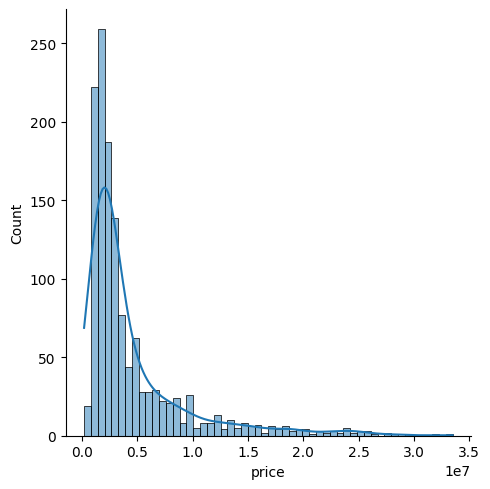

In [52]:
sns.displot(df_analyze['price'], kde=True)

As always, `price` is positively skewed. Proper way to address this is to use log price later in our model as it is much less skewed, shown in the below plot

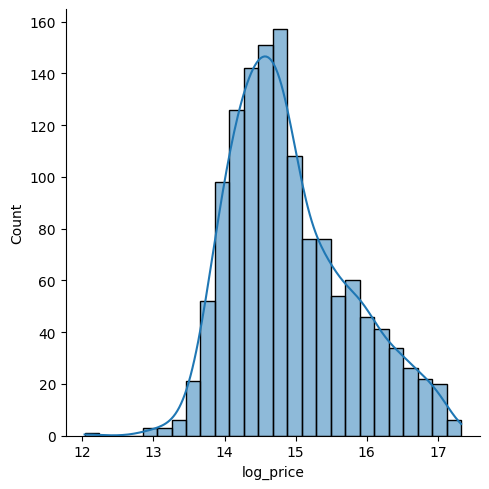

In [53]:
df_analyze['log_price'] = np.log(df_analyze['price'])
sns.displot(df_analyze['log_price'], kde=True)

### Plot numerical features

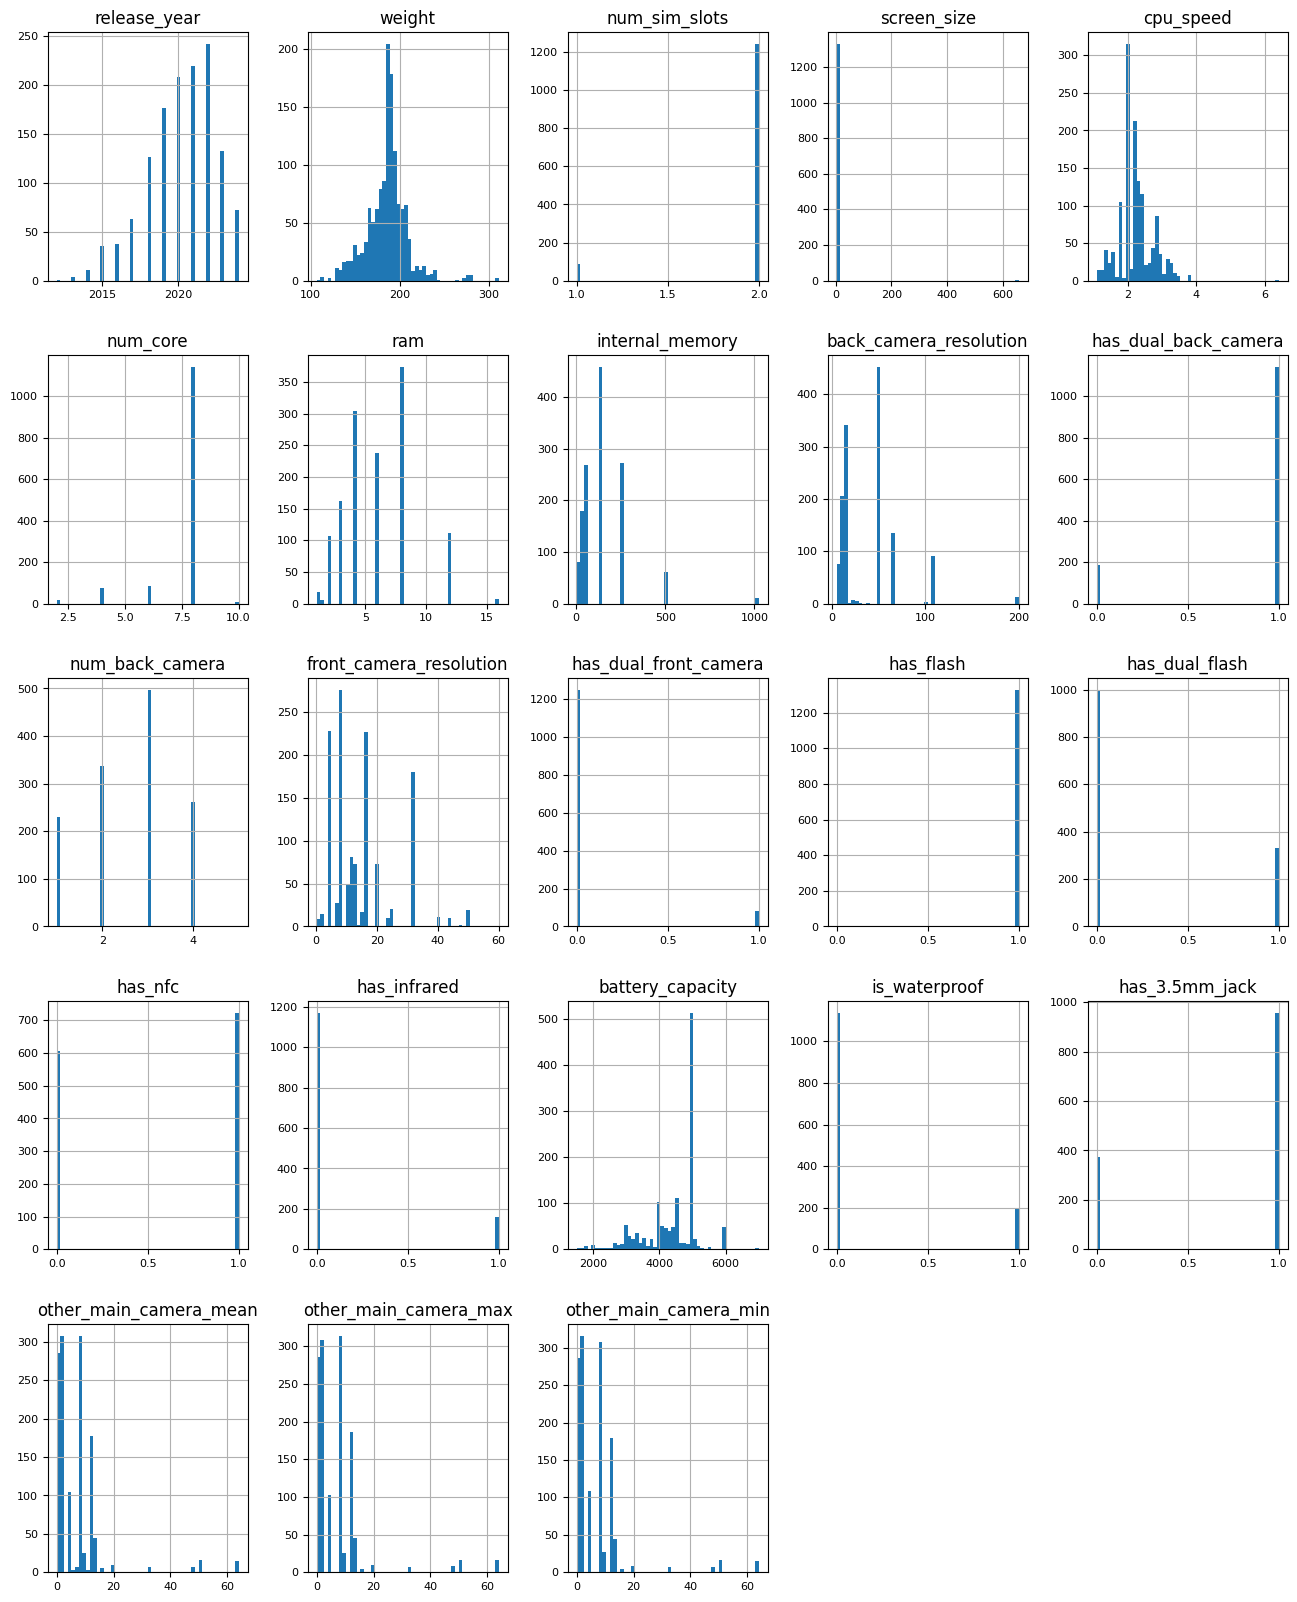

In [54]:
df_num = df_analyze.select_dtypes(include=['float64'])
df_num = df_num.drop(columns=['price', 'log_price'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

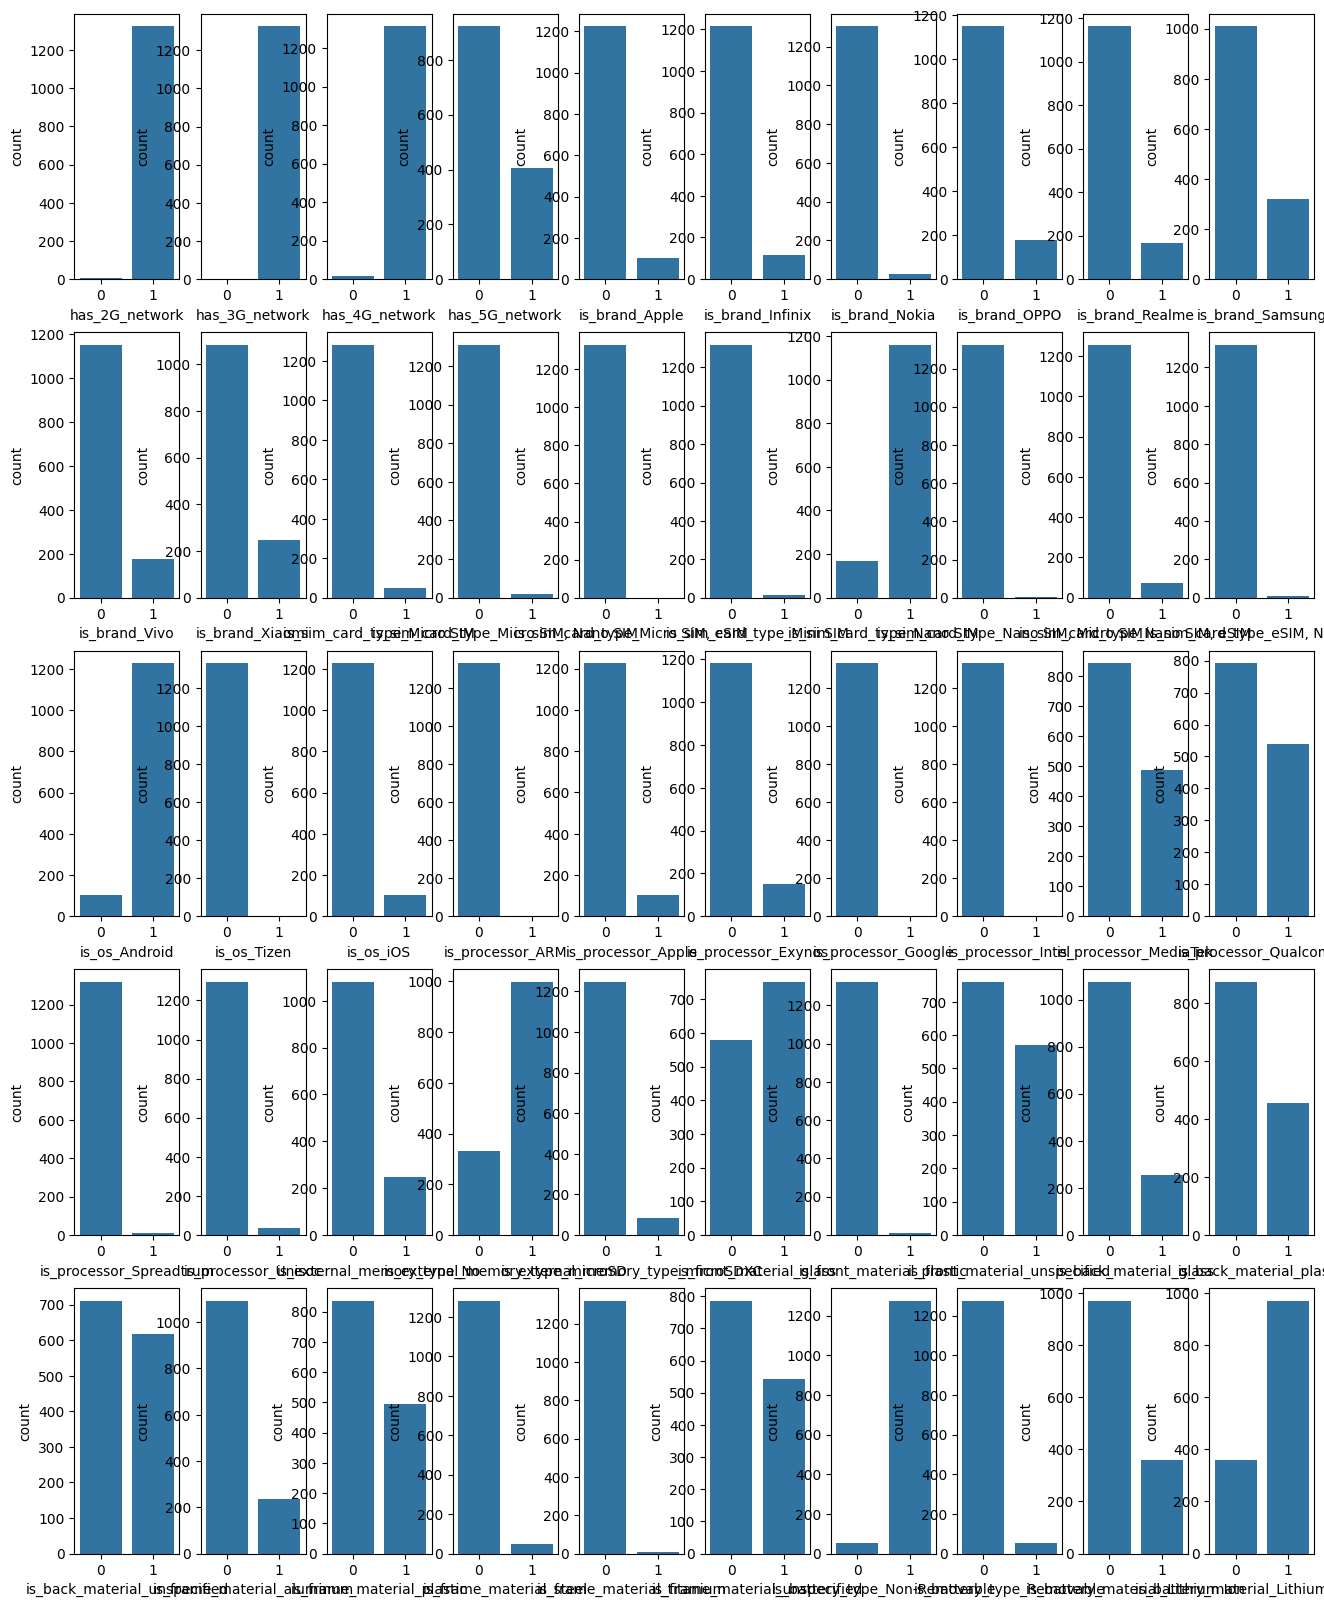

In [55]:
df_int = df_analyze.select_dtypes(include=['int'])
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(16,20))
axes = axes.flatten()
columns = df_int.columns

for i, col in enumerate(columns):
    sns.countplot(x=col, data=df_int, ax=axes[i])

# 3. Model Building

In [56]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [57]:
price_cols = ['price', 'log_price']
X = df_analyze.loc[:, ~df_analyze.columns.isin(price_cols)]
y = df_analyze.loc[:, 'log_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
    )

In [58]:
feature_correlation = X_train.corr()
highly_correlated_cols = np.where(feature_correlation.abs() >= 0.8)

for i,j in zip(highly_correlated_cols[0], highly_correlated_cols[1]):
    if i>j:
        print(X_train.columns[i], X_train.columns[j])

other_main_camera_max other_main_camera_mean
other_main_camera_min other_main_camera_mean
other_main_camera_min other_main_camera_max
is_os_Android is_brand_Apple
is_os_iOS is_brand_Apple
is_os_iOS is_os_Android
is_processor_Apple is_brand_Apple
is_processor_Apple is_os_Android
is_processor_Apple is_os_iOS
is_external_memory_type_microSD is_external_memory_type_No
is_front_material_unspecified is_front_material_glass
is_back_material_unspecified is_front_material_glass
is_back_material_unspecified is_front_material_unspecified
is_frame_material_plastic is_back_material_plastic
is_frame_material_unspecified is_front_material_glass
is_frame_material_unspecified is_front_material_unspecified
is_battery_type_Removable is_battery_type_Non-Removable
is_battery_material_Lithium Polymer is_battery_material_Lithium Ion


In [59]:
X_train = X_train.drop(
    columns=['other_main_camera_max', 'other_main_camera_min', 'is_os_Android', 'is_os_iOS', 'is_processor_Apple',
             'is_external_memory_type_microSD', 'is_front_material_unspecified', 'is_back_material_unspecified',
             'is_frame_material_plastic', 'is_frame_material_unspecified', 'is_battery_type_Removable', 'is_battery_material_Lithium Polymer']
    )

In [60]:
X_test = X_test.drop(
    columns=['other_main_camera_max', 'other_main_camera_min', 'is_os_Android', 'is_os_iOS', 'is_processor_Apple',
             'is_external_memory_type_microSD', 'is_front_material_unspecified', 'is_back_material_unspecified',
             'is_frame_material_plastic', 'is_frame_material_unspecified', 'is_battery_type_Removable', 'is_battery_material_Lithium Polymer']
    )

### Baseline model: Linear Models

In [61]:
def evaluate_errors(y_true, y_pred):
    return pd.Series({
        'mse':mean_squared_error(y_true, y_pred),
        'mae':mean_absolute_error(y_true, y_pred),
        'r2':r2_score(y_true, y_pred)
    })

In [62]:
reg = LinearRegression()
reg.fit(X_train, y_train)
print('Linear regression\n', evaluate_errors(y_test, reg.predict(X_test)))

reg = Ridge()
reg.fit(X_train, y_train)
reg.score(X_test, y_test)
print('Ridge regression\n', evaluate_errors(y_test, reg.predict(X_test)))

reg = Lasso()
reg.fit(X_train, y_train)
print('Lasso regression\n', evaluate_errors(y_test, reg.predict(X_test)))

reg = ElasticNet()
reg.fit(X_train, y_train)
print('ElasticNet regression\n', evaluate_errors(y_test, reg.predict(X_test)))

Linear regression
 mse    0.619153
mae    0.313977
r2     0.076040
dtype: float64
Ridge regression
 mse    0.622465
mae    0.313419
r2     0.071099
dtype: float64
Lasso regression
 mse    0.309603
mae    0.415063
r2     0.537980
dtype: float64
ElasticNet regression
 mse    0.300266
mae    0.404845
r2     0.551915
dtype: float64


### Random Forest

In [63]:
params = {
    'max_depth':range(2,6),
    'n_estimators':range(100, 600, 100),
    'max_features':['sqrt', 'log2', None]
}

In [64]:
best_rf = GridSearchCV(estimator=RandomForestRegressor(random_state=42), param_grid=params, cv=5)
best_rf.fit(X_train, y_train)
print('Best Random Forest Params:', best_rf.best_params_)
print('Best Random Forest\n', evaluate_errors(y_test, best_rf.predict(X_test)))

Best Random Forest Params: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 500}
Best Random Forest
 mse    0.170343
mae    0.291522
r2     0.745797
dtype: float64


### Gradient Boosting

In [65]:
params = {
    'max_depth':range(2,6),
    'n_estimators':range(100, 600, 100),
    'learning_rate':[.001, .002, .005, .01, .02, .05, .1]
}

In [66]:
best_gbr = GridSearchCV(estimator=GradientBoostingRegressor(random_state=42), param_grid=params, cv=5)
best_gbr.fit(X_train, y_train)
print('Best GBR Params:', best_gbr.best_params_)
print('Best GBR\n', evaluate_errors(y_test, best_gbr.predict(X_test)))

Best GBR Params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best GBR
 mse    0.135979
mae    0.251566
r2     0.797079
dtype: float64


### XGBoost

In [67]:
from xgboost import XGBRegressor

In [68]:
params = {
    'max_depth':range(2,6),
    'n_estimators':range(100, 600, 100),
    'learning_rate':[.001, .002, .005, .01, .02, .05, .1]
}

In [69]:
best_xgb = GridSearchCV(estimator=XGBRegressor(random_state=42), param_grid=params, cv=5)
best_xgb.fit(X_train, y_train)
print('Best XGB Params:', best_xgb.best_params_)
print('Best XGB\n', evaluate_errors(y_test, best_xgb.predict(X_test)))

Best XGB Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500}
Best XGB
 mse    0.134139
mae    0.248449
r2     0.799825
dtype: float64
